# Replication Study

Replication of the paper 'Probing of Triple Higgs Coupling at LHC using Machine Learning'. The dataset has already been generated and now a MPNN network is to be generated. Plots and Graphs will be generated at the end for confirmation.

## Getting Plots

In [1]:
from dataClass import GenDataset
import numpy as np

Welcome to JupyROOT 6.24/00


### K-Factor

$K_f = \frac{\sigma_{NLO}}{\sigma_{LO}}$

Therefore, it is used to get the aproximate experimental value that is at NLO level without generating all the events

### Normalization

This is the ratio of the luminosity generated over what should have been generated had the event happened at LHC

In [2]:
kr = 1.54/1.71
process  = ['ttbar','llbj','tWj','ttV','ttbarh','taubb','hh']
k_factor = [1.0,1.0,1.0,1.54,1.0,1.0,1.0]
cs     =   [1.61,0.21,0.24,0.05,0.02,8.38*1e-7,2.19*1e-5]
cs_norm =  [953.6]

## Create Heat Map

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

In [4]:
def getJetPlot(i : str):
    print("INFO : Generating for " + i)
    s1 = GenDataset("/home/blizzard/Tests/bbWW/"+ i + "_10k/Events/run_01/tag_1_delphes_events.root")
    s1.createArrays()
    
    eta = []
    for j in range(len(s1.datasetDict)):
        eta.append(s1.datasetDict[j]["etaList"])

    phi = []
    for j in range(len(s1.datasetDict)):
        phi.append(s1.datasetDict[j]["phiList"])

    arr = []
    for j in range(len(s1.datasetDict)):
        arr.append(s1.datasetDict[j]["fourMomenta"])

    jetEta = np.array([])
    jetPhi = np.array([])

    for j in range(len(s1.datasetDict)):
        for k in range(len(arr[j])):
            if arr[j][k][2] != 0:
                jetEta = np.append(jetEta,eta[j][k])
                jetPhi = np.append(jetPhi,phi[j][k])

    sns.jointplot(x=jetEta,y=jetPhi,kind='hex')
    plt.plot()

INFO : Generating for ttbar
INFO : Started Filtering Particles
INFO : Done Filtering Particles
INFO : Generating for llbj
INFO : Started Filtering Particles
INFO : Done Filtering Particles
INFO : Generating for tWj
INFO : Started Filtering Particles
INFO : Done Filtering Particles
INFO : Generating for ttV
INFO : Started Filtering Particles
INFO : Done Filtering Particles
INFO : Generating for ttbarh
INFO : Started Filtering Particles
INFO : Done Filtering Particles
INFO : Generating for taubb
INFO : Started Filtering Particles
INFO : Done Filtering Particles
INFO : Generating for hh
INFO : Started Filtering Particles
INFO : Done Filtering Particles


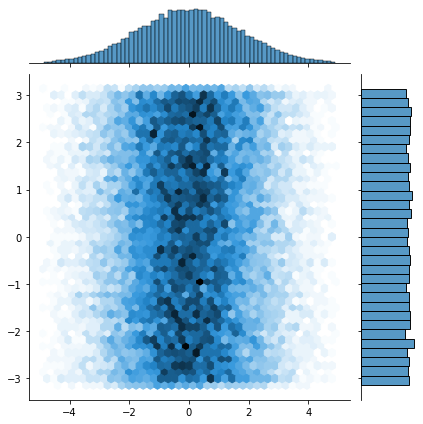

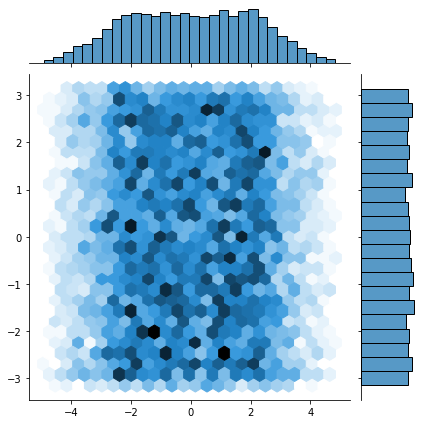

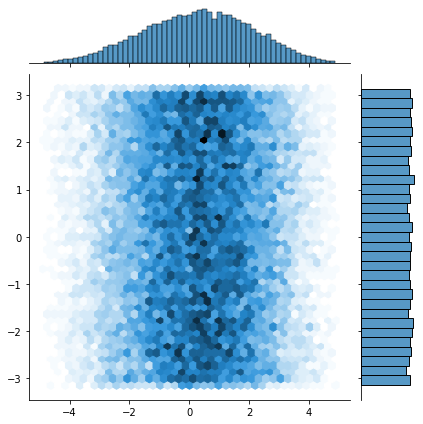

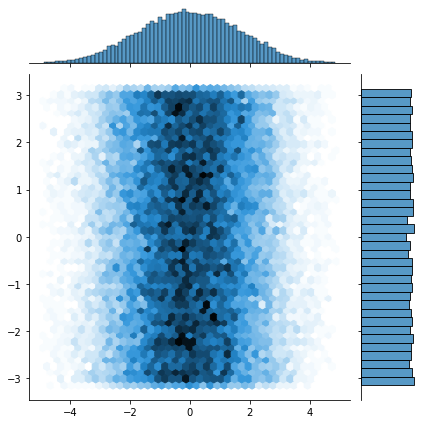

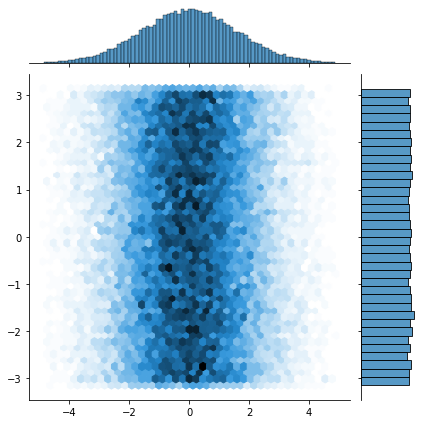

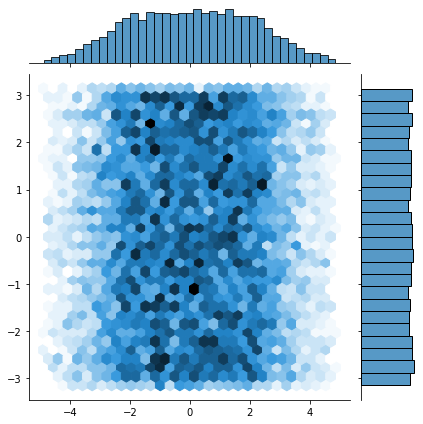

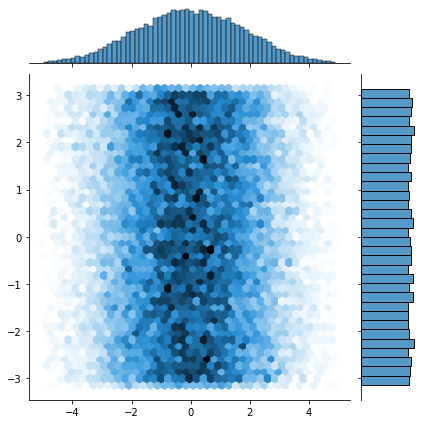

In [5]:
for i in process:
    getJetPlot(i)

In [5]:
from ROOT import TLorentzVector
import h5py
import awkward as ak
import json

In [6]:
def getArraysFromFile(inputFile : str):
    '''
    Accessor function that gives back lists from hdf5 file. Due to the various conversions from 
    List --> Awkward --> HDF5 file, this function is made as to make the conversion back to list 
    simple.
    Parameters :
    ------------
    inputFile : str, required
        The hdf5 file with the converted list
    Returns :
    ---------
    particleArray : list
        The list that contains the 4-momenta of every particle in every event.
    azArray : list
        The list that contains the azimuthal angle of every particle in every event.
    '''

    print("INFO : Started Getting Data From File")

    hf = h5py.File(inputFile,'r')
    partArray = hf.get("ParticleArray")
    azimuthalArray = hf.get("AzimuthalAngle")
    etaArray = hf.get("EtaAngle")
    phiArray = hf.get("PhiAngle")

    reconstitutedPartArray = ak.from_buffers(
        ak.forms.Form.fromjson(partArray.attrs["form"]),
        json.loads(partArray.attrs["length"]),
        {k: np.asarray(v) for k, v in partArray.items()},
    )

    reconstitutedAzAngle = ak.from_buffers(
        ak.forms.Form.fromjson(azimuthalArray.attrs["form"]),
        json.loads(azimuthalArray.attrs["length"]),
        {k: np.asarray(v) for k, v in azimuthalArray.items()},
    )

    reconstitutedEtaAngle = ak.from_buffers(
        ak.forms.Form.fromjson(etaArray.attrs["form"]),
        json.loads(etaArray.attrs["length"]),
        {k: np.asarray(v) for k, v in etaArray.items()},
    )

    reconstitutedPhiAngle = ak.from_buffers(
        ak.forms.Form.fromjson(phiArray.attrs["form"]),
        json.loads(phiArray.attrs["length"]),
        {k: np.asarray(v) for k, v in phiArray.items()},
    )
    
    particleArray = ak.to_list(reconstitutedPartArray)
    azArray = ak.to_list(reconstitutedAzAngle)
    etaArray = ak.to_list(reconstitutedEtaAngle)
    phiArray = ak.to_list(reconstitutedPhiAngle)

    print("INFO : Done Getting Data from File")
    return particleArray,azArray,etaArray,phiArray

In [7]:
def getMbb(proc : str):

    mbbTemp = []
    part,_,eta,phi = getArraysFromFile('../../datasets/partonCuts/'+proc+'_10k.h5')

    for i in range(len(part)):
        ptJetsb = []        # List containing b-tagged Jets
        ptAllJets = []      # List of all the Jets
                             
        flag = True         # Flag that True -> Survive the Cut,
                            # False -> Does not Survive the Cut
                
        for momenta in part[i]:
             
            # Getting a List of Jets to  
            # compute cuts on them
               
            # B-Tagged Jet
            if momenta[2] == 1:
                ptJetsb.append(momenta[4])
                ptAllJets.append(momenta[4])
               
            # Non B-Tagged Jet    
            elif momenta[2] == -1:
                ptAllJets.append(momenta[4])

        # Remove all the invalid records to save time by not computing when not required
        if not flag:
            continue
        
        # Record invalid is less than 2 b-tagged Jets
        if len(ptJetsb) < 2:
            continue

        # Record invalid if the two leading momenta are not of b-tagged Jets
        ptAllJets.sort(reverse=True)
        if ptAllJets[0] not in ptJetsb or ptAllJets[1] not in ptJetsb:
            continue

        # Getting the Index of Leading Jets
        jetIndex = []
        for momenta in part[i]:
            for j in range(2):
                if momenta[2] == 1 and momenta[4] == ptAllJets[j]:
                    jetIndex.append(part[i].index(momenta))

        Jet1 = TLorentzVector()
        Jet2 = TLorentzVector()
        Jet1.SetPtEtaPhiM(part[i][jetIndex[0]][4],
                          eta[i][jetIndex[0]],
                          phi[i][jetIndex[0]],
                          part[i][jetIndex[0]][-1])

        Jet2.SetPtEtaPhiM(part[i][jetIndex[1]][4],
                          eta[i][jetIndex[1]],
                          phi[i][jetIndex[1]],
                          part[i][jetIndex[1]][-1])
        mbbTemp.append((Jet1 + Jet2).M())
    
    return mbbTemp

In [8]:
mbb = []
for i in process:
    mbb.append(getMbb(i))

INFO : Started Getting Data From File
INFO : Done Getting Data from File
INFO : Started Getting Data From File
INFO : Done Getting Data from File
INFO : Started Getting Data From File
INFO : Done Getting Data from File
INFO : Started Getting Data From File
INFO : Done Getting Data from File
INFO : Started Getting Data From File
INFO : Done Getting Data from File
INFO : Started Getting Data From File
INFO : Done Getting Data from File
INFO : Started Getting Data From File
INFO : Done Getting Data from File


In [9]:
process.reverse()
rev_proc = process
process.reverse()

(0.1, 10000.0)

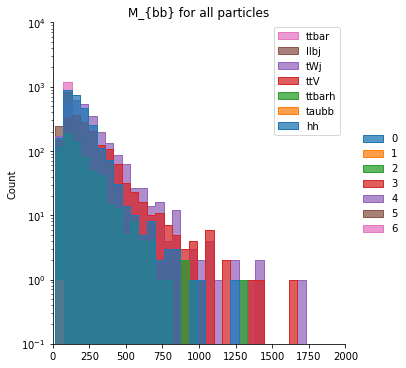

In [10]:
sns.displot(mbb,bins=30,log_scale=[False,True],element='step')
plt.title('M_{bb} for all particles')
plt.legend(rev_proc)
plt.xlim(0,2000)
plt.ylim(0.1,10e3)

In [25]:
i = 1
mbb[i] = getMbb(process[i])

INFO : Started Getting Data From File
INFO : Done Getting Data from File


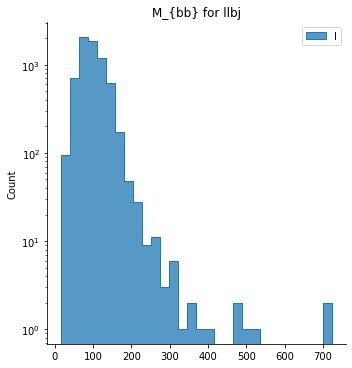

In [26]:
sns.displot(mbb[i],bins=30,log_scale=[False,True],element='step')
plt.title('M_{bb} for ' + str(process[i]))
plt.legend(process[i])
#plt.xlim(0,2000)
#plt.ylim(0.1,10e3)

(0.1, 100000.0)

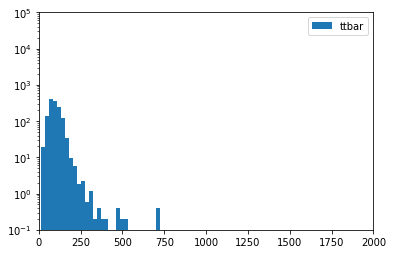

In [27]:
#for i in range(1,2):
plt.hist(mbb[i],bins=30,log=True,weights=np.ones_like(mbb[i])/5)
plt.legend(process)
plt.xlim(0,2000)
plt.ylim(0.1,10e4)

In [ ]:
def getMll(proc : str):

    part,_,eta,phi = getArraysFromFile('../../datasets/partonCuts/'+proc+'_10k.h5')
    mllTemp = []

    for i in range(len(part)):
        leptonIndex = []
        for momenta in i["fourMomenta"]:
            if momenta[1] != 0:
                    leptonIndex.append(i["fourMomenta"].index(momenta))
            
        for j in range(len(leptonIndex)):
            for k in range(j+1,len(leptonIndex)):
                    
                Jet1 = TLorentzVector()
                Jet2 = TLorentzVector()

                Jet1.SetPtEtaPhiM(i['fourMomenta'][leptonIndex[j]][4],
                                  i['etaList'][leptonIndex[j]],
                                  i['phiList'][leptonIndex[j]],
                                  i['fourMomenta'][leptonIndex[j]][-1])
                                  
                Jet2.SetPtEtaPhiM(i['fourMomenta'][leptonIndex[k]][4],
                                  i['etaList'][leptonIndex[k]],
                                  i['phiList'][leptonIndex[k]],
                                  i['fourMomenta'][leptonIndex[k]][-1])
                
                mllTemp.append((Jet1 + Jet2).M())
    
    return mllTemp

In [ ]:
mll = []
for i in process:
    mll.append(getMll(i))

In [ ]:
g = sns.displot(mll,bins=75,log_scale=[False,True],element='step')
plt.title('M_{ll}')
plt.legend(process)
g.set(xlim=(0,1000))
g._legend.remove()